In [83]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow.keras.metrics as metrics
from keras_tuner import Objective

In [2]:
df = pd.read_csv("Resources/Aggregated_Metrics_By_Video.csv")
df

,Video,Video title,Video pub­lish time,Com­ments ad­ded,Shares,Dis­likes,Likes,Sub­scribers lost,Sub­scribers gained,RPM (USD),CPM (USD),Av­er­age per­cent­age viewed (%),Av­er­age view dur­a­tion,Views,Watch time (hours),Sub­scribers,Your es­tim­ated rev­en­ue (USD),Im­pres­sions,Im­pres­sions click-through rate (%)
0,Total,NaN,NaN,14197,39640,3902,225021,45790,229241,5.276,11.990,26.61,0:03:25,5568487,317602.3536,183451,29068.652,100954064,3.16
1,4OZip0cgOho,How I Would Learn Data Science (If I Had to St...,"May 8, 2020",907,9583,942,46903,451,46904,6.353,12.835,36.65,0:03:09,1253559,65850.7042,46453,7959.533,26498799,3.14
2,78LjdAAw0wA,100K Channel Update + AMA Stream!,"Nov 12, 2020",412,4,4,130,15,12,2.668,6.259,6.26,0:05:14,2291,200.2966,-3,6.113,188318,0.72
3,hO_YKK_0Qck,Uber Driver to Machine Learning Engineer in 9 ...,"Jul 16, 2020",402,152,15,881,9,198,9.516,11.695,15.12,0:10:21,21350,3687.3387,189,202.963,442334,2.53
4,uXLnbdHMf8w,Why I'm Starting Data Science Over Again.,"Aug 29, 2020",375,367,22,2622,40,1957,3.143,7.943,33.41,0:02:36,49564,2148.3110,1917,155.779,521185,4.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,FBgs-BSTIJE,Demystifying Data Science Roles,"Nov 30, 2018",3,5,1,48,1,8,5.218,16.232,55.55,0:03:28,978,56.5930,7,5.103,26202,2.24
220,Yr5T3T4tq-g,Most Data Science Hopefuls Overlook This Impor...,"May 25, 2019",3,0,0,44,0,5,3.374,15.596,58.62,0:02:06,548,19.2752,5,1.849,21780,1.61
221,j-Z-je6K4Yg,IT'S NOT TOO LATE TO LEARN CODE!,"Dec 18, 2018",3,1,0,35,0,7,3.784,12.590,60.52,0:01:52,721,22.5450,7,2.728,18635,2.65
222,5jntoZX-Tc8,NASA Physicist Turned Data Scientist (Tim Bowl...,"May 5, 2019",2,5,0,38,0,3,2.651,12.206,16.93,0:03:09,1094,57.6363,3,2.900,34642,1.99


In [3]:
# Drop the header line
df = df.drop(labels = 0, axis = 0)

In [4]:
df = df.drop(['Video', 'Video title', 'Video pub\xadlish time', 'Sub\xadscribers lost', 
                        'Sub\xadscribers gained', 'Av\xader\xadage per\xadcent\xadage viewed (%)', 
                        'Av\xader\xadage view dur\xada\xadtion', 'Sub\xadscribers', 
                        'Your es\xadtim\xadated rev\xaden\xadue (USD)', 'Im\xadpres\xadsions', 
                        'Im\xadpres\xadsions click-through rate (%)'], axis=1)

In [5]:
#Fix the two columns with "\xad" in it before starting
df.rename(columns = {'Com\xadments ad\xadded':'Comments added', 'Dis\xadlikes':'Dislikes'}, inplace=True)

In [6]:
#Since there are only two nulls, we'll just remove those two rows.
df = df.dropna(axis=0)

In [7]:
df.isna().sum()

Comments added        0
Shares                0
Dislikes              0
Likes                 0
RPM (USD)             0
CPM (USD)             0
Views                 0
Watch time (hours)    0
dtype: int64

In [8]:
df.columns

Index(['Comments added', 'Shares', 'Dislikes', 'Likes', 'RPM (USD)',
       'CPM (USD)', 'Views', 'Watch time (hours)'],
      dtype='object')

In [9]:
y = df["RPM (USD)"]

In [10]:
X = df.drop("RPM (USD)", axis = 1)

In [11]:
X

,Comments added,Shares,Dislikes,Likes,CPM (USD),Views,Watch time (hours)
1,907,9583,942,46903,12.835,1253559,65850.7042
2,412,4,4,130,6.259,2291,200.2966
3,402,152,15,881,11.695,21350,3687.3387
4,375,367,22,2622,7.943,49564,2148.3110
5,329,118,15,590,7.425,13429,1034.3945
...,...,...,...,...,...,...,...
218,4,5,0,30,37.786,1225,9.6188
219,3,5,1,48,16.232,978,56.5930
220,3,0,0,44,15.596,548,19.2752
221,3,1,0,35,12.590,721,22.5450


In [12]:
df.mean()

Comments added           63.968326
Shares                  179.298643
Dislikes                 17.638009
Likes                  1017.316742
RPM (USD)                 4.478240
CPM (USD)                11.440303
Views                 25180.425339
Watch time (hours)     1436.927080
dtype: float64

In [13]:
df.max()

Comments added        9.070000e+02
Shares                9.583000e+03
Dislikes              9.420000e+02
Likes                 4.690300e+04
RPM (USD)             1.038700e+01
CPM (USD)             3.778600e+01
Views                 1.253559e+06
Watch time (hours)    6.585070e+04
dtype: float64

In [14]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [15]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [16]:
# find number of columns to find the input dimension
len(X.columns)

7

In [17]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn = Sequential()

# First hidden layer
nn.add(Dense(units=8, activation="relu", input_dim=7))

# Second hidden layer
nn.add(Dense(units=8, activation="relu"))

# Output layer
nn.add(Dense(units=1, activation='relu'))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 64        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 145 (580.00 Byte)
Trainable params: 145 (580.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])

In [19]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
6/6 [==============================] - 0s 2ms/step - loss: 22.5293 - accuracy: 0.0000e+00
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 22.3626 - accuracy: 0.0000e+00
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 22.1730 - accuracy: 0.0000e+00
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 21.9066 - accuracy: 0.0000e+00
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 21.5517 - accuracy: 0.0000e+00
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 21.1008 - accuracy: 0.0000e+00
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 20.6443 - accuracy: 0.0000e+00
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 20.1618 - accuracy: 0.0000e+00
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 19.6649 - accuracy: 0.0000e+00
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 19.1787 - 

6/6 [==============================] - 0s 2ms/step - loss: 3.1692 - accuracy: 0.0000e+00
Epoch 82/100
6/6 [==============================] - 0s 2ms/step - loss: 3.1569 - accuracy: 0.0000e+00
Epoch 83/100
6/6 [==============================] - 0s 2ms/step - loss: 3.1355 - accuracy: 0.0000e+00
Epoch 84/100
6/6 [==============================] - 0s 2ms/step - loss: 3.1224 - accuracy: 0.0000e+00
Epoch 85/100
6/6 [==============================] - 0s 1ms/step - loss: 3.1026 - accuracy: 0.0000e+00
Epoch 86/100
6/6 [==============================] - 0s 2ms/step - loss: 3.0880 - accuracy: 0.0000e+00
Epoch 87/100
6/6 [==============================] - 0s 2ms/step - loss: 3.0742 - accuracy: 0.0000e+00
Epoch 88/100
6/6 [==============================] - 0s 2ms/step - loss: 3.0611 - accuracy: 0.0000e+00
Epoch 89/100
6/6 [==============================] - 0s 2ms/step - loss: 3.0418 - accuracy: 0.0000e+00
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 3.0242 - accuracy: 0.00

In [20]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

2/2 - 0s - loss: 2.1012 - accuracy: 0.0000e+00 - 100ms/epoch - 50ms/step
Loss: 2.1011641025543213, Accuracy: 0.0


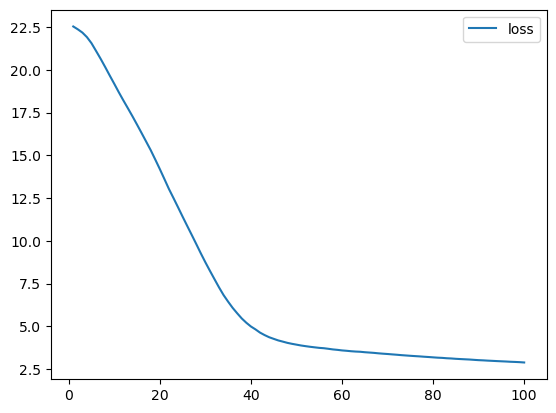

In [21]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")
plt.show()

In [22]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn = Sequential()

# First hidden layer
nn.add(Dense(units=8, activation="relu", input_dim=7))

# Second hidden layer
nn.add(Dense(units=8, activation="relu"))

# Output layer
nn.add(Dense(units=1, activation='relu'))

# Check the structure of the model
nn.summary()

# Recompile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_absolute_percentage_error"])

# Train the model with fewer epochs
fit_model = nn.fit(X_train_scaled, y_train, epochs=50)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 64        
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 145 (580.00 Byte)
Trainable params: 145 (580.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
6/6 [==============================] - 0s 1ms/step - loss: 23.6100 - mean_absolute_percentage_error: 99.7675
Epoch 2/50
6/6 [==============================] - 0s 2ms/step - loss: 23.5276 - mean_absolute_percentage_error: 99.6132
Epoch 3/50
6/6 [========================

In [23]:
# Evaluate the model using the test data
model_loss, model_percent_error = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Mean Absolute Percent Error: {model_percent_error}")

2/2 - 0s - loss: 5.7807 - mean_absolute_percentage_error: 41.1382 - 87ms/epoch - 43ms/step
Loss: 5.7806525230407715, Mean Absolute Percent Error: 41.13819122314453


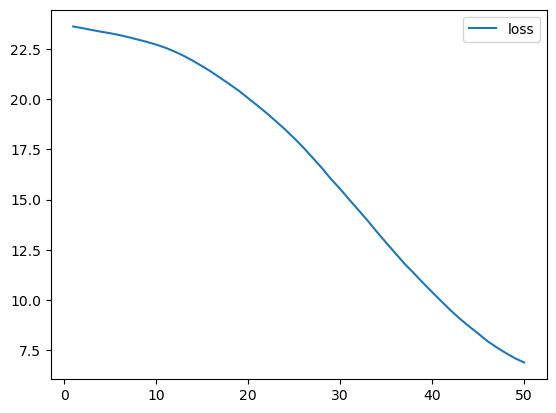

In [24]:
# Create a history dataframe
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")
plt.show()

In [105]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh'])

    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=15,
        step=5), activation=activation, input_dim=7))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 7)):
        nn_model.add(Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=15,
            step=5),
            activation=activation))

    nn_model.add(Dense(units=1, activation="relu"))

    # Compile the model
    nn_model.compile(loss="mean_squared_error", optimizer='adam',metrics = ['mean_squared_error'])

    return nn_model

In [106]:
# make a tuner object to find the best hyperparameters

tuner = kt.Hyperband(
    create_model,
    objective='mean_squared_error',
    max_epochs=20,
    hyperband_iterations=2)

INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [107]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Trial 56 Complete [00h 00m 04s]
mean_squared_error: 12.512813568115234

Best mean_squared_error So Far: 6.0876145362854
Total elapsed time: 00h 01m 59s
INFO:tensorflow:Oracle triggered exit


In [109]:
# Find the best three models
top_model = tuner.get_best_models(1)[0]

model_loss = top_model.evaluate(X_test_scaled,y_test,verbose=1)
print(f"Loss: {model_loss}")

2/2 [==============================] - 0s 6ms/step - loss: 4.5779 - mean_squared_error: 4.5779
Loss: [4.577914237976074, 4.577914237976074]


In [110]:
# Find top model hyperparameters and print the values
top_hypers = tuner.get_best_hyperparameters(1)
for param in top_hypers:
    print(param.values)

{'activation': 'tanh', 'first_units': 1, 'num_layers': 6, 'units_0': 6, 'units_1': 11, 'units_2': 11, 'units_3': 1, 'units_4': 11, 'units_5': 6, 'units_6': 6, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [112]:
top_model.save("Revenue_prediction.h5")

/Users/Shadow/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
